In [9]:
from    typing              import  *
from    typing_extensions   import  Self

from    tqdm.notebook       import  tqdm

import  numpy               as  np
import  matplotlib.pyplot   as  plt

import  torch
from    torch.utils.data    import  Dataset, DataLoader


from    pathlib             import  Path
root_dir    = r"/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE"
path_root   = Path(root_dir)
path_lib    = path_root / "python_deep_numerical"
path_data   = path_root / "datasets"

import  sys
sys.path.append( str(path_lib) )
from    pytorch.layers    import  FourierBoltzmannLayer
from    pytorch.torch_numerical         import  utils
from    pytorch.torch_numerical.solvers import  FastSM_Boltzmann_VHS


dtype  = torch.float32
dtype_complex = utils.dtype_real_to_complex(dtype)
device = torch.device('cuda:2')
__dtype_str = str(dtype).split(".")[-1]
dtype_and_device = {'dtype': dtype, 'device': device}
print(f"Device for computation\n>>> {device}")

Device for computation
>>> cuda:2


In [10]:
DIMENSION:  int     = 2
RESOLUTION: int     = 64
VHS_ALPHA:  float   = 0.0
file = np.load(path_data / f"{__dtype_str}/Boltzmann__alpha_{int(VHS_ALPHA)}__res_{RESOLUTION}.npz")

V_MAX:      float   = float(file['v_max'])
DELTA_V:    float   = (2*V_MAX) / RESOLUTION
v_grid              = utils.velocity_grid(DIMENSION, RESOLUTION, V_MAX, **dtype_and_device)
FFT_NORM:   str     = 'forward'

VHS_COEFF:  float   = file['vhs_coeff']

In [11]:
class CustomDataset(Dataset):
    def __init__(
            self,
            distr:      torch.Tensor,
            gain_fft:   torch.Tensor,
            loss_fft:   torch.Tensor,
            vhs_alpha:  Optional[torch.Tensor]  = None,
            dim:        Optional[int]           = None,
            squeeze_space: bool = False,
        ) -> Self:
        self.dim:       int                         = dim
        self.distr:     torch.Tensor                = distr
        self.gain_fft:  torch.Tensor                = gain_fft
        self.loss_fft:  torch.Tensor                = loss_fft
        self.vhs_alpha: Optional[torch.Tensor]      = vhs_alpha
        self.__fft_dim: tuple[int] = tuple(range(1+dim, 1+2*dim))
        
        if squeeze_space:
            self.distr      = self.distr.reshape(distr.size(0), *distr.shape[-1-dim:])
            self.gain_fft   = self.gain_fft.reshape(gain_fft.size(0), *gain_fft.shape[-1-dim:])
            self.loss_fft   = self.loss_fft.reshape(loss_fft.size(0), *loss_fft.shape[-1-dim:])
            self.__fft_dim  = tuple(range(1, 1+dim))
            
        return
    
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        if self.vhs_alpha:
            return self.distr[index], self.gain_fft[index], self.loss_fft[index], self.vhs_alpha[index]
        else:
            return self.distr[index], self.gain_fft[index], self.loss_fft[index]
    
    def __len__(self) -> int:
        return self.distr.size(0)
    
    
    @property
    def fft_dim(self) -> tuple[int]:
        return self.__fft_dim

In [12]:
dataset  = CustomDataset(
    torch.tensor(file['data'], dtype=dtype),
    torch.tensor(file['gain_fft'], dtype=dtype_complex),
    torch.tensor(file['loss_fft'], dtype=dtype_complex),
    dim=2,
    squeeze_space=False,
)
dataloader  = DataLoader(dataset, batch_size=32, shuffle=True)
FFT_DIM = dataset.fft_dim

In [13]:
sm_object   = FastSM_Boltzmann_VHS(
    dimension   = DIMENSION,
    v_num_grid  = RESOLUTION,
    v_max       = V_MAX,
    
    vhs_coeff   = VHS_COEFF,
    vhs_alpha   = VHS_ALPHA,
    
    quad_order_uniform  = 25,
    quad_order_legendre = 50,
    quad_order_lebedev  = 7,
    
    dtype   = dtype,
    device  = device, 
)
n_weights   = sm_object.approximation_level
specnet     = FourierBoltzmannLayer(DIMENSION, RESOLUTION//2, n_channels=1, n_weights=n_weights).to(device)
specnet.eval()

print(sm_object.fsm_scale.shape)
print(sm_object.fsm_phase_1.shape)
print(sm_object.fsm_phase_2.shape)
_rep = sm_object.fsm_phase_1.size(-1)
param_scale = sm_object.fsm_scale.repeat((*utils.ones(DIMENSION+2), _rep)).reshape(specnet.params_gamma.shape).type(dtype_complex).to(device)
param_phase_1 = sm_object.fsm_phase_1.reshape(specnet.params_alpha.shape).type(dtype_complex).to(device)
param_phase_2 = sm_object.fsm_phase_2.reshape(specnet.params_alpha.shape).type(dtype_complex).to(device)
param_diag  = sm_object.kernel_diag.reshape(specnet.params_diag.shape).type(dtype_complex).to(device)
specnet.params_gamma.data   = param_scale
specnet.params_alpha.data   = param_phase_1
specnet.params_beta.data    = param_phase_2
specnet.params_diag.data    = param_diag

print(specnet)

torch.Size([64, 64, 1, 50, 1])
torch.Size([64, 64, 1, 50, 25])
torch.Size([64, 64, 1, 50, 25])
==============================< FourierBoltzmannLayer >==============================
[ Subnetworks ]

-------------------------------------------------------------------------------------
[ Parameters ]

( params_alpha )
* Shape:       [64, 64, 1, 1250]
* Data type:   torch.complex64
( params_beta )
* Shape:       [64, 64, 1, 1250]
* Data type:   torch.complex64
( params_gamma )
* Shape:       [64, 64, 1, 1250]
* Data type:   torch.complex64
( params_diag )
* Shape:       [64, 64, 1]
* Data type:   torch.complex64
-------------------------------------------------------------------------------------
Number of parameters: 30728192


In [ ]:
abs_error:  float = 0.0
rel_error:  float = 0.0
abs_error_gain: float = 0.0
rel_error_gain: float = 0.0
abs_error_loss: float = 0.0
rel_error_loss: float = 0.0
norms_Q:    list[torch.Tensor] = []

dv = DELTA_V**DIMENSION

data:       torch.Tensor
gain_fft:   torch.Tensor
loss_fft:   torch.Tensor
for data, gain_fft, loss_fft in tqdm(dataloader):
    data        = data.to(device)
    gain_fft    = gain_fft.to(device)
    loss_fft    = loss_fft.to(device)
    target_collision:   torch.Tensor = torch.fft.ifftn(gain_fft-loss_fft, dim=FFT_DIM, norm=FFT_NORM).real

    data_fft:   torch.Tensor = torch.fft.fftn(data, dim=FFT_DIM, norm=FFT_NORM)
    # pred_gain_fft = sm_object.compute_gain_fft(None, data_fft)
    # pred_loss_fft = sm_object.compute_loss_fft(None, data_fft)
    pred_gain_fft = specnet.compute_gain_fft(data_fft)
    pred_loss_fft = specnet.compute_loss_fft(data_fft)
    pred_fft = pred_gain_fft - pred_loss_fft
    pred_collision:     torch.Tensor = torch.fft.ifftn(pred_fft, dim=FFT_DIM, norm=FFT_NORM).real

    abs_error += utils.absolute_error(pred_collision, target_collision).sum().item()
    rel_error += utils.relative_error(pred_collision, target_collision).sum().item()
    norms_Q.append(target_collision.reshape(target_collision.size(0), -1).norm(p=2, dim=-1) * dv)
    abs_error_gain += utils.absolute_error(pred_gain_fft, gain_fft).sum().item()
    rel_error_gain += utils.relative_error(pred_gain_fft, gain_fft).sum().item()
    abs_error_loss += utils.absolute_error(pred_loss_fft, loss_fft).sum().item()
    rel_error_loss += utils.relative_error(pred_loss_fft, loss_fft).sum().item()

abs_error       *= dv/len(dataset)
rel_error       /= len(dataset)
abs_error_gain  *= dv/len(dataset)
rel_error_gain  /= len(dataset)
abs_error_loss  *= dv/len(dataset)
rel_error_loss  /= len(dataset)
norms_Q = torch.cat(norms_Q, dim=0)
print(f"Absolute error:         {abs_error:.4e}")
print(f"Relative error:         {rel_error:.4e}")
print(f"Absolute error gain:    {abs_error_gain:.4e}")
print(f"Relative error gain:    {rel_error_gain:.4e}")
print(f"Absolute error loss:    {abs_error_loss:.4e}")
print(f"Relative error loss:    {rel_error_loss:.4e}")

  0%|          | 0/94 [00:00<?, ?it/s]

Absolute error:         1.0690e-08
Relative error:         1.4307e-02
Absolute error gain:    2.2755e-10
Relative error gain:    3.5915e-08
Absolute error loss:    5.1116e-15
Relative error loss:    7.0939e-13


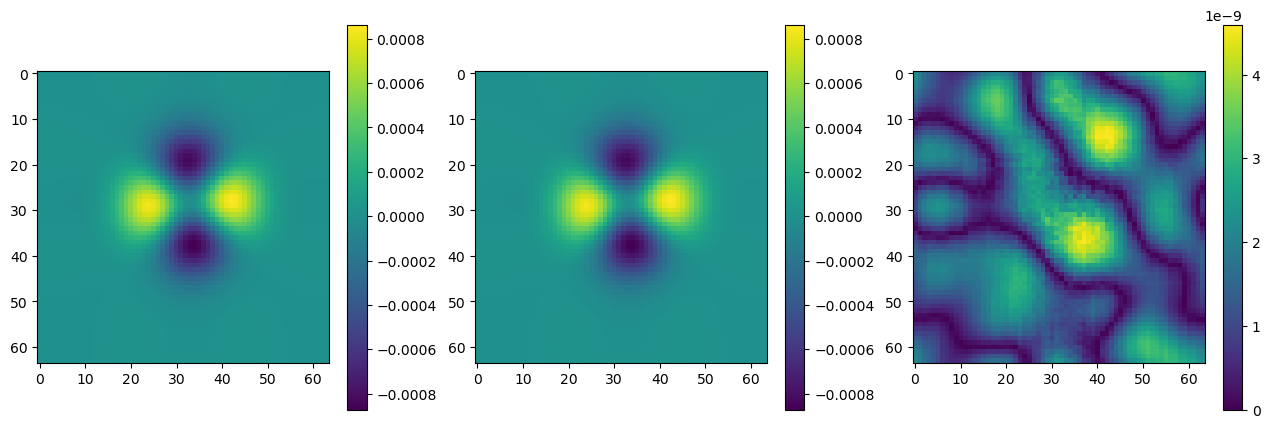

In [24]:
idx = torch.randint(0, len(data), (1,)).item()
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
d1 = pred_collision[idx].reshape(RESOLUTION, RESOLUTION).detach().cpu().numpy()
d2 = target_collision[idx].reshape(RESOLUTION, RESOLUTION).detach().cpu().numpy()
d3 = (pred_collision-target_collision)[idx].reshape(RESOLUTION, RESOLUTION).detach().cpu().numpy()
fig.colorbar(axes[0].imshow(d1))
fig.colorbar(axes[1].imshow(d2))
fig.colorbar(axes[2].imshow(np.abs(d3)))
plt.show()

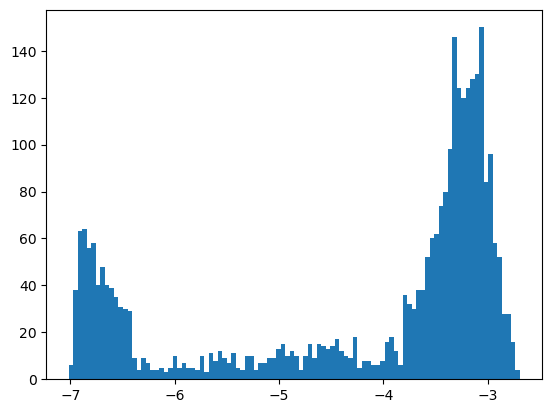

In [16]:
plt.hist(torch.log10(norms_Q).detach().cpu(), bins=100)
plt.show()

End of file